In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
df = pd.read_csv('./tesla_stock.csv')
df.head()
print(df.shape)

(1509, 7)


In [3]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [4]:
from datetime import datetime

In [5]:
df.Date = pd.to_datetime(df['Date'])

In [6]:
df.Date.head()

0   2014-01-02
1   2014-01-03
2   2014-01-06
3   2014-01-07
4   2014-01-08
Name: Date, dtype: datetime64[ns]

In [7]:
df.set_index = df.Date

In [8]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,29.959999,30.496,29.309999,30.020000,30.020000,30942000
1,2014-01-03,30.000000,30.438,29.719999,29.912001,29.912001,23475000
2,2014-01-06,30.000000,30.080,29.048000,29.400000,29.400000,26805500
3,2014-01-07,29.524000,30.080,29.049999,29.872000,29.872000,25170500
4,2014-01-08,29.770000,30.740,29.752001,30.256001,30.256001,30816000


In [9]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1509.000000,1509.000000,1509.000000,1509.000000,1509.000000,1.509000e+03
mean,52.226978,53.099993,51.320423,52.241292,52.241292,3.327480e+07
std,11.027391,11.172793,10.862098,11.032614,11.032614,2.059614e+07
min,28.100000,29.400000,27.334000,27.868000,27.868000,3.540000e+06
25%,43.570000,44.296001,42.854000,43.625999,43.625999,2.036200e+07
50%,49.778000,50.480000,49.116001,49.768002,49.768002,2.814550e+07
75%,61.467999,62.678001,60.299999,61.688000,61.688000,3.959250e+07
max,87.000000,87.061996,85.269997,86.188004,86.188004,1.682485e+08


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509 entries, 0 to 1508
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1509 non-null   datetime64[ns]
 1   Open       1509 non-null   float64       
 2   High       1509 non-null   float64       
 3   Low        1509 non-null   float64       
 4   Close      1509 non-null   float64       
 5   Adj Close  1509 non-null   float64       
 6   Volume     1509 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 82.6 KB


<AxesSubplot:title={'center':'Tesla Stock Closing Prices in past 5 years'}, xlabel='Days', ylabel='Closing Price'>

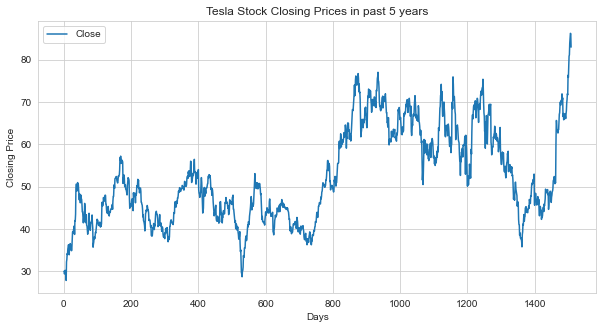

In [11]:
plt.title('Tesla Stock Closing Prices in past 5 years')
plt.xlabel('Days')
plt.ylabel('Closing Price')
df.Close.plot(legend = True, figsize = (10,5))

<AxesSubplot:title={'center':'Tesla Stock Volume trading in past 5 years'}, xlabel='Days', ylabel='Volume of stocks'>

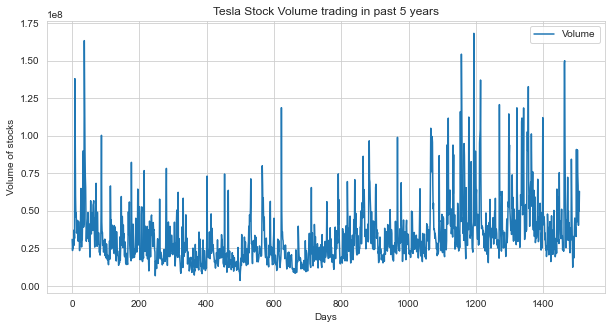

In [12]:
plt.title('Tesla Stock Volume trading in past 5 years')
plt.xlabel('Days')
plt.ylabel('Volume of stocks')
df.Volume.plot(legend = True, figsize = (10,5))

In [13]:
# Smoothing the graph
# Ploting prices with rolling mean
df['Close_10'] = df['Close'].rolling(10).mean()
df['Close_50'] = df['Close'].rolling(50).mean()
df.head(12)

,Date,Open,High,Low,Close,Adj Close,Volume,Close_10,Close_50
0,2014-01-02,29.959999,30.496000,29.309999,30.020000,30.020000,30942000,NaN,NaN
1,2014-01-03,30.000000,30.438000,29.719999,29.912001,29.912001,23475000,NaN,NaN
2,2014-01-06,30.000000,30.080000,29.048000,29.400000,29.400000,26805500,NaN,NaN
3,2014-01-07,29.524000,30.080000,29.049999,29.872000,29.872000,25170500,NaN,NaN
4,2014-01-08,29.770000,30.740000,29.752001,30.256001,30.256001,30816000,NaN,NaN
5,2014-01-09,30.500000,30.686001,29.370001,29.506001,29.506001,26910000,NaN,NaN
6,2014-01-10,29.691999,29.780001,28.450001,29.143999,29.143999,37230500,NaN,NaN
7,2014-01-13,29.156000,29.400000,27.563999,27.868000,27.868000,31580500,NaN,NaN
8,2014-01-14,28.100000,32.400002,27.334000,32.254002,32.254002,138035000,NaN,NaN
9,2014-01-15,33.689999,34.445999,32.419998,32.826000,32.826000,102328000,30.1058,NaN


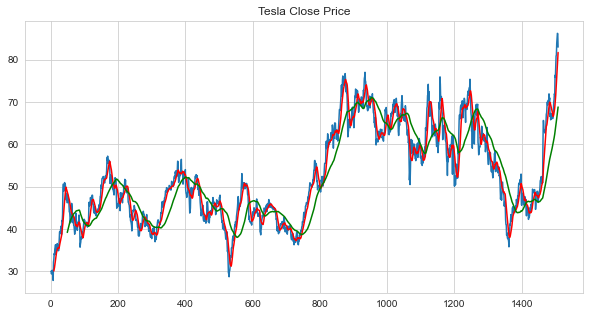

In [14]:
ax = df.Close.plot(x = 'Date', y = 'Close', title = 'Tesla Close Price', figsize = (10,5))
df.Close_10.plot(x = 'Date', y = 'Close_10', color = 'r', ax = ax)
df.Close_50.plot(x = 'Date', y = 'Close_50', color = 'g', ax = ax)
plt.ioff()

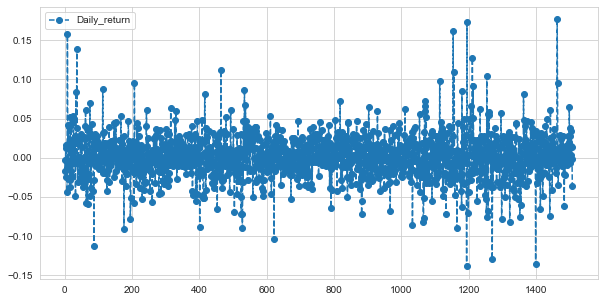

In [15]:
# Daily returns
df['Daily_return'] = df['Close'].pct_change()
df['Daily_return'].plot(figsize = (10,5), legend = True, linestyle = '--', marker = 'o')
plt.ioff()

# Maximum daily fluctuation in this stock is 15 %

d:\envs\sota\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Daily_return', ylabel='Density'>

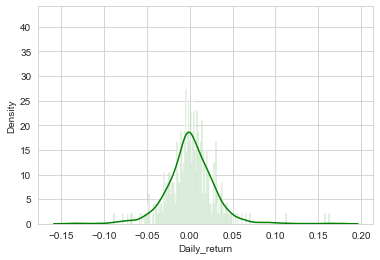

In [16]:
# Average daily returns
sns.distplot(df['Daily_return'], bins = 1000, color = 'g')

<AxesSubplot:>

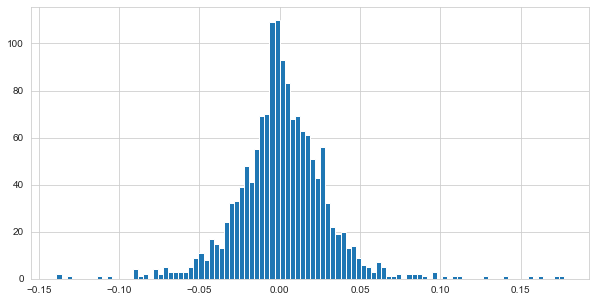

In [17]:
df['Daily_return'].hist(bins = 100, figsize = (10,5))

# Daily fluctuation of stock normal distribution is between +-2 %

In [18]:
ser = np.array(range(len(df)))
ind_series = pd.Series(ser)
len(ind_series)

1509

In [19]:
df.set_index = ind_series
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_10,Close_50,Daily_return
0,2014-01-02,29.959999,30.496,29.309999,30.020000,30.020000,30942000,NaN,NaN,NaN
1,2014-01-03,30.000000,30.438,29.719999,29.912001,29.912001,23475000,NaN,NaN,-0.003598
2,2014-01-06,30.000000,30.080,29.048000,29.400000,29.400000,26805500,NaN,NaN,-0.017117
3,2014-01-07,29.524000,30.080,29.049999,29.872000,29.872000,25170500,NaN,NaN,0.016054
4,2014-01-08,29.770000,30.740,29.752001,30.256001,30.256001,30816000,NaN,NaN,0.012855


In [20]:
df2 = df.drop(['Date','Close_10','Close_50'],axis = 1, errors = 'ignore')
df2.head()

,Open,High,Low,Close,Adj Close,Volume,Daily_return
0,29.959999,30.496,29.309999,30.020000,30.020000,30942000,NaN
1,30.000000,30.438,29.719999,29.912001,29.912001,23475000,-0.003598
2,30.000000,30.080,29.048000,29.400000,29.400000,26805500,-0.017117
3,29.524000,30.080,29.049999,29.872000,29.872000,25170500,0.016054
4,29.770000,30.740,29.752001,30.256001,30.256001,30816000,0.012855


In [21]:
df2_pct = df2.pct_change()
df2_pct = pd.DataFrame(df2_pct)
df2_pct['Date'] = df['Date']
df2_pct.head()

,Open,High,Low,Close,Adj Close,Volume,Daily_return,Date
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-02
1,0.001335,-0.001902,0.013988,-0.003598,-0.003598,-0.241322,NaN,2014-01-03
2,0.000000,-0.011762,-0.022611,-0.017117,-0.017117,0.141874,3.757911,2014-01-06
3,-0.015867,0.000000,0.000069,0.016054,0.016054,-0.060995,-1.937928,2014-01-07
4,0.008332,0.021941,0.024165,0.012855,0.012855,0.224290,-0.199293,2014-01-08


In [22]:
df2_pct['Close'].quantile(0.05)

-0.042532631745063616

In [23]:
df2_pct['Close'].quantile(0.60)

0.00529392489357523

In [24]:
# -0.042 means that 95% of the times the worst daily Loss will not exceed 4.25%

In [25]:
# Value at risk using Monte Carlo simulation
days = 365
dt = 1/365
mu = df2_pct.mean()['Close']
sigma = df2_pct.std()['Close']

d:\envs\sota\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  after removing the cwd from sys.path.


In [26]:
def monte_price(start,days,mu,sigma):
    price = np.zeros(days)
    price[0] = start
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    for x in range(1,days):
        shock[x] = np.random.normal(loc = mu*dt, scale = sigma*np.sqrt(dt))
        drift[x] = mu*dt
        price[x] = price[x-1] + (price[x-1] * (drift[x] + shock[x]))
    return price

In [27]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_10,Close_50,Daily_return
0,2014-01-02,29.959999,30.496,29.309999,30.020000,30.020000,30942000,NaN,NaN,NaN
1,2014-01-03,30.000000,30.438,29.719999,29.912001,29.912001,23475000,NaN,NaN,-0.003598
2,2014-01-06,30.000000,30.080,29.048000,29.400000,29.400000,26805500,NaN,NaN,-0.017117
3,2014-01-07,29.524000,30.080,29.049999,29.872000,29.872000,25170500,NaN,NaN,0.016054
4,2014-01-08,29.770000,30.740,29.752001,30.256001,30.256001,30816000,NaN,NaN,0.012855


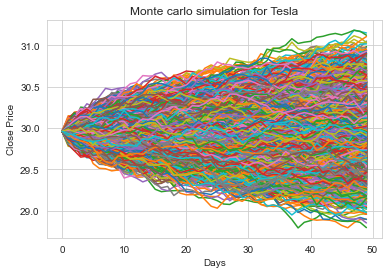

In [32]:
start = 29.959999
days = 50
for i in range(10000):
    plt.plot(monte_price(start,days,mu,sigma))

plt.xlabel('Days')
plt.ylabel('Close Price')
plt.title('Monte carlo simulation for Tesla')
plt.ioff()

In [42]:
runs = 10000
simulations = np.zeros(runs)

for run in range(runs):
    simulations[run] = monte_price(start,days, mu, sigma)[days - 1]

Text(0.5, 1.0, 'Tesla Closing price distribution after 365 days')

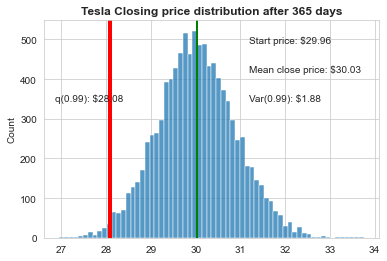

In [43]:
q = np.percentile(simulations,1)
sns.histplot(simulations)

# starting price
plt.figtext(0.6,0.8, s="Start price: $%.2f" %start)

# Mean close price
plt.axvline(x = simulations.mean(), linewidth = 2, color = 'g')
plt.figtext(0.6,0.7, s="Mean close price: $%.2f" %simulations.mean())

# Variance of price within 99% confidence level
plt.figtext(0.6,0.6, s="Var(0.99): $%.2f" %(start - q,))

# 1% quantile result
plt.figtext(0.15, 0.6, "q(0.99): $%.2f" % q)
plt.axvline(x = q, linewidth = 4, color = 'r')

plt.title('Tesla Closing price distribution after 365 days', weight = 'bold')

In [44]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [ ]:
tsplot(df.Close, lags=60)

In [ ]:
close_diff = df.Close - df.Close.shift(24)
tsplot(close_diff[24:], lags=60)

In [ ]:
close_diff = close_diff - close_diff.shift(1)
tsplot(close_diff[24+1:], lags=60)

In [ ]:
from tqdm import tqdm_notebook
from itertools import product 
import warnings
warnings.filterwarnings("ignore")

In [ ]:
ps = range(4, 8)
d=1 
qs = range(5, 8)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 #season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

In [ ]:
def optimize_sarima(parameters_list,d,D,s):
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = sm.tsa.statespace.SARIMAX(df.Close, order=(param[0],d,param[1]),
                                              seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_params = param
        results.append([param, model.aic])
    
    result_table = pd.DataFrame(results)
    result_table.columns = ['Parameters','aic']
    result_table = result_table.sort_values(by='aic',ascending = True).reset_index(drop=True)
    return result_table

In [ ]:
%%time
result_table = optimize_sarima(parameters_list, d, D, s)

In [ ]:
result_table.head()

In [ ]:
p, q, P, Q = result_table.Parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df.Close, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

In [ ]:
tsplot(best_model.resid[24+1:], lags=60)

In [ ]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
def plotSARIMA(series, model, n_steps):
    # adding model values
    data = pd.Series(series.copy())
    dataframe = pd.DataFrame(data)
    dataframe.columns = ['actual']
    dataframe['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    dataframe['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = dataframe.shape[0], end = dataframe.shape[0]+n_steps)
    forecast = dataframe.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(dataframe.actual[s+d:], dataframe.arima_model[s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(dataframe.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(dataframe.actual, label="actual")
    plt.legend()
    plt.grid(True);

In [ ]:
# Forecasting of next 100 days
plotSARIMA(df.Close, best_model, 100)

In [ ]:
new_df = pd.DataFrame(df.Close.copy())
new_df.columns = ['y']

In [ ]:
for i in range(6,25):
    new_df['lag_{}'.format(i)] = new_df.y.shift(i)

In [ ]:
new_df.tail()

In [ ]:
# Prediction using linear model

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
def time_series_train_test_split(X,y,test_size):
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_train = y.iloc[:test_index]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [ ]:
X = new_df.dropna().drop(['y'],axis = 1)
y = new_df.dropna().y

In [ ]:
X_train, X_test, y_train, y_test = time_series_train_test_split(X,y,0.3)

In [ ]:
X_train.shape

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
lr = LinearRegression()
lr.fit(X_train_scaled,y_train)

In [ ]:
def plotModelResults(model, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=False, 
                     plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [ ]:
plotModelResults(lr,plot_intervals=True)
plotCoefficients(lr)

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

In [ ]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=False)
plotCoefficients(ridge)

In [ ]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=False)
plotCoefficients(lasso)

In [ ]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

In [ ]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)

In [ ]:
# We conclude that -
# SARIMAX model forecasts the values with error of 2.!!% (Lowest)